In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import cv2
import glob
import os.path as osp
import os
import seaborn as sns

In [2]:
masks = pd.read_csv('train_ship_segmentations_v2.csv')

In [3]:
train_dir = "train_v2"
test_dir = "test_v2"
print(f"Files in train dir: {len(os.listdir(train_dir))}\nFiles in test dir: {len(os.listdir(test_dir))}")

Files in train dir: 192556
Files in test dir: 15606


# As we see we have 192556 images in train dir and 15606 images in test dir

In [4]:
not_jpg_train_files = [filename for filename in os.listdir(train_dir) if not filename.endswith('.jpg')]
not_jpg_test_files = [filename for filename in os.listdir(test_dir) if not filename.endswith('.jpg')]
print(f"""Checking if in train and test are only photos:
Not jpg files in train: {len(not_jpg_train_files)}
Not jpg files in test: {len(not_jpg_test_files)}""")

Checking if in train and test are only photos:
Not jpg files in train: 0
Not jpg files in test: 0


# We have only .jpg files in directories

In [5]:
train_csv_path = "train_ship_segmentations_v2.csv"
train_df = pd.read_csv(train_csv_path, index_col='ImageId')#load df with RLE encoding 
print(f"Shape with duplicates:{train_df.shape}")
train_df = train_df[~train_df.index.duplicated(keep='first')] # Get rid of duplicates
print(f"Shape without duplicates:{train_df.shape} (the same amount we have in train dir)")
train_df.head()

Shape with duplicates:(231723, 1)
Shape without duplicates:(192556, 1) (the same amount we have in train dir)


EncodedPixels
ImageId                                                         
00003e153.jpg                                                NaN
0001124c7.jpg                                                NaN
000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
0001b1832.jpg                                                NaN

# We have a bunch of duplicates in .csv file 

In [6]:
train_df['file_size_kb'] = train_df.index.map(lambda c_img_id: os.stat(os.path.join(train_dir, c_img_id)).st_size/1024)
print(f"amount of corrupted images: {len(train_df[train_df['file_size_kb']<50])}")

amount of corrupted images: 1266


# Also corrupted images 

<Axes: >

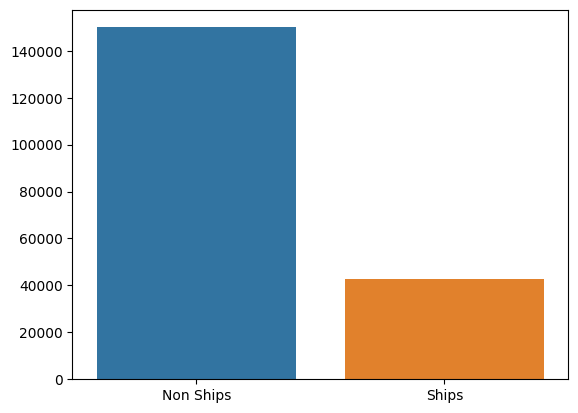

In [7]:
trgt01 = train_df.fillna(0)
trgt01['EncodedPixels'] = (trgt01['EncodedPixels'] !=0).astype("uint8")
value = trgt01['EncodedPixels'].value_counts().tolist()

sns.barplot(x =  ["Non Ships", "Ships"], y = value)

# As we can see images with no ships are a majority class

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [9]:
# Decoder for csv file with masks
def rle_decode(mask_rle, shape=(768, 768), resize=False):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    img = img.reshape(shape).T
    if resize:
        img = cv2.resize(img, (224, 224), cv2.INTER_AREA)
    return img
temp = train_df.dropna()

In [10]:
temp["size_of_ship"] = temp['EncodedPixels'].apply(lambda x: np.sum(rle_decode(x)))

C:\Users\A-Gamebook 149\AppData\Local\Temp\ipykernel_6720\1642175439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["size_of_ship"] = temp['EncodedPixels'].apply(lambda x: np.sum(rle_decode(x)))


<Axes: xlabel='size_of_ship', ylabel='Count'>

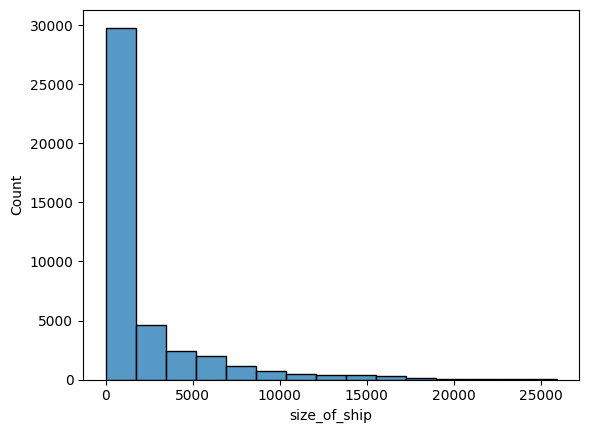

In [11]:
sns.histplot(temp['size_of_ship'], bins= 15) 

# Most of images with ships have small masks

In [12]:
# Function for decoding a csv file with masks into masks images
def mask_as_image(masks, resize=True):
    possible_masks = np.zeros((768, 768))
    for mask in masks:
        if isinstance(mask, float):
            break
        else:
            mask_image = rle_decode(mask, resize=True)
            if resize:
                mask_image = cv2.resize(mask_image, (768,768), cv2.INTER_AREA)
                mask_image = cv2.normalize(mask_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

            possible_masks += mask_image
    return possible_masks

In [13]:
# Function for defining files with and without ships
def get_train(paths, next_path, csv, ship=True):
    csv_mask = csv.copy()
    new_lst = []
    if ship:
        df = csv_mask[csv_mask["EncodedPixels"].notna()].copy()
    else:
        df = csv_mask[csv_mask["EncodedPixels"].isna()].copy()
    df = df.drop_duplicates(subset="ImageId")
    for rows in (df.iterrows()):
        new_lst.append(next_path + "/" + rows[1].ImageId)
    return new_lst

In [14]:
# Code for dataset initialization
class shipDataset(Dataset):
    def __init__(self, paths, transforms=None, train=True, test=False, mask_file=None):
        self.paths = paths
        self.transforms = transforms
        self.train = train
        self.mask_file = mask_file
        self.test = test
        self.permute = False

    def __len__(self):
        return len(self.paths)

    # Function for reading and changing images from a dataset
    def __getitem__(self, idx):
        p = self.paths[idx]
        imageId = p.split('/')[-1]
        image = cv2.imread(p)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        image = cv2.resize(image, (768, 768), cv2.INTER_AREA)
        if self.train:
            mask_list = self.mask_file.loc[self.mask_file["ImageId"] == imageId, "EncodedPixels"].tolist()
            masks = mask_as_image(mask_list, resize=True)
            if self.transforms:
                image = self.transforms(image=image)
                masks = self.transforms(masks)

            masks = torch.from_numpy(masks).float()
        image = torch.from_numpy(image).float()

        if self.permute:
            image = image.permute(2, 0, 1)
        if self.test:
            return image, imageId

        else:
            return image, masks

In [15]:
# Identification of all picture titles
filenames_train = glob.glob(osp.join('train_v2', '*.jpg'))
test_paths = glob.glob(osp.join('test_v2', '*.jpg'))
mask_file = pd.read_csv('train_ship_segmentations_v2.csv')


# Reduce train size
train_ship = get_train(filenames_train, "train_v2", mask_file, True)
train_na_ship = get_train(filenames_train, "train_v2", mask_file, False)

# Finding corrupted images
train_df['file_size_kb'] = train_df.index.map(lambda c_img_id: os.stat(os.path.join(train_dir, c_img_id)).st_size/1024)

# Reduce size of train with and without ships
train_na_ship = random.sample(train_na_ship, int(len(train_na_ship) * 0.01))
train_ship = random.sample(train_ship, int(len(train_ship) * 0.05))
filenames_train = train_na_ship + train_ship
print(f'len(data) = {len(filenames_train)}')

# Train/Val split
train_paths, validation_paths = train_test_split(filenames_train, test_size=0.3, random_state=42)
print(f'len(test)/[len(test)+len(train)] = len(validation)/[len(validation)+len(train)]')
print(
    f'{len(test_paths) / (len(test_paths) + len(filenames_train))} = {len(validation_paths) / (len(validation_paths) + len(train_paths))}')

# DataSets
train_dataset = shipDataset(train_paths, transforms=False, train=True, mask_file=mask_file)
valid_dataset = shipDataset(validation_paths, train=True, mask_file=mask_file)
test_dataset = shipDataset(test_paths, train=False, test=True)

# DataLoaders
BS = 1
NW = 0
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

len(data) = 3627
len(test)/[len(test)+len(train)] = len(validation)/[len(validation)+len(train)]
0.811417875526439 = 0.3002481389578164


In [16]:
# Function for showing an image, a mask, and a mask on top of an image
def show_image_with_mask(imgs, masks, rows, cols):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 8))
    for i in range(len(imgs)):
        img = imgs[i]
        mask = masks[i]
        img = img.numpy()
        mask = mask.numpy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        axarr[0].axis('off')
        axarr[0].imshow(img)
        axarr[1].axis('off')
        axarr[1].imshow(mask)
        axarr[2].axis('off')
        axarr[2].imshow(img)
        axarr[2].imshow(mask, alpha=0.4)
        plt.tight_layout(h_pad=0.0, w_pad=0.0)

# There is some visualizations

0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


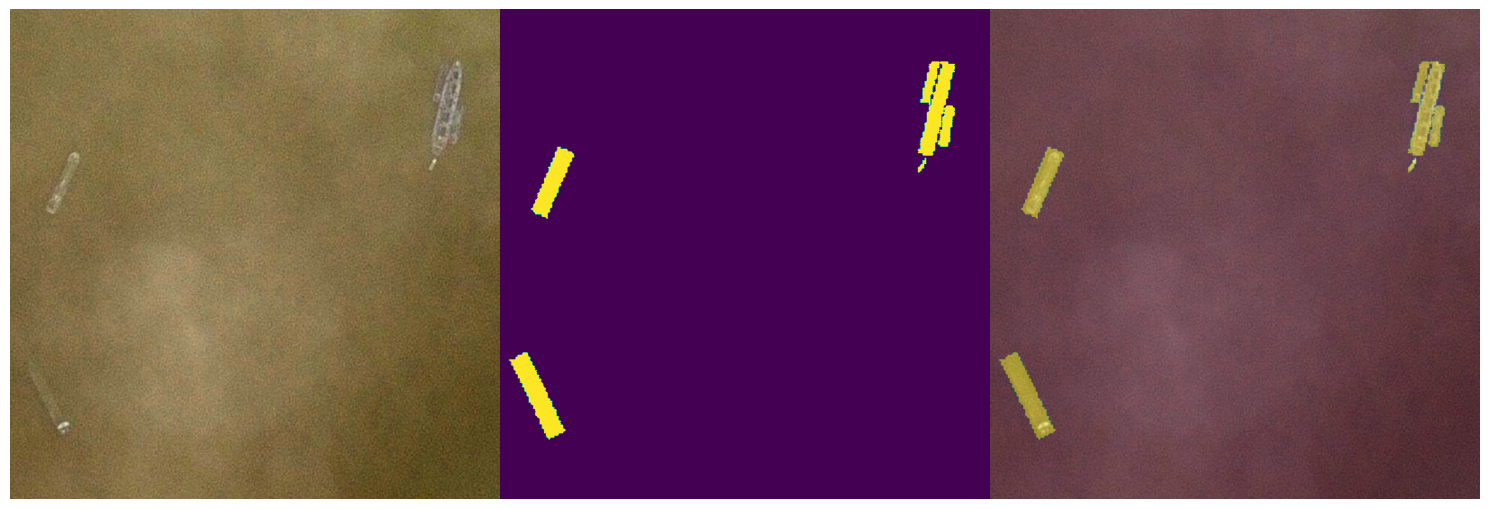

1it [00:00,  1.16it/s]

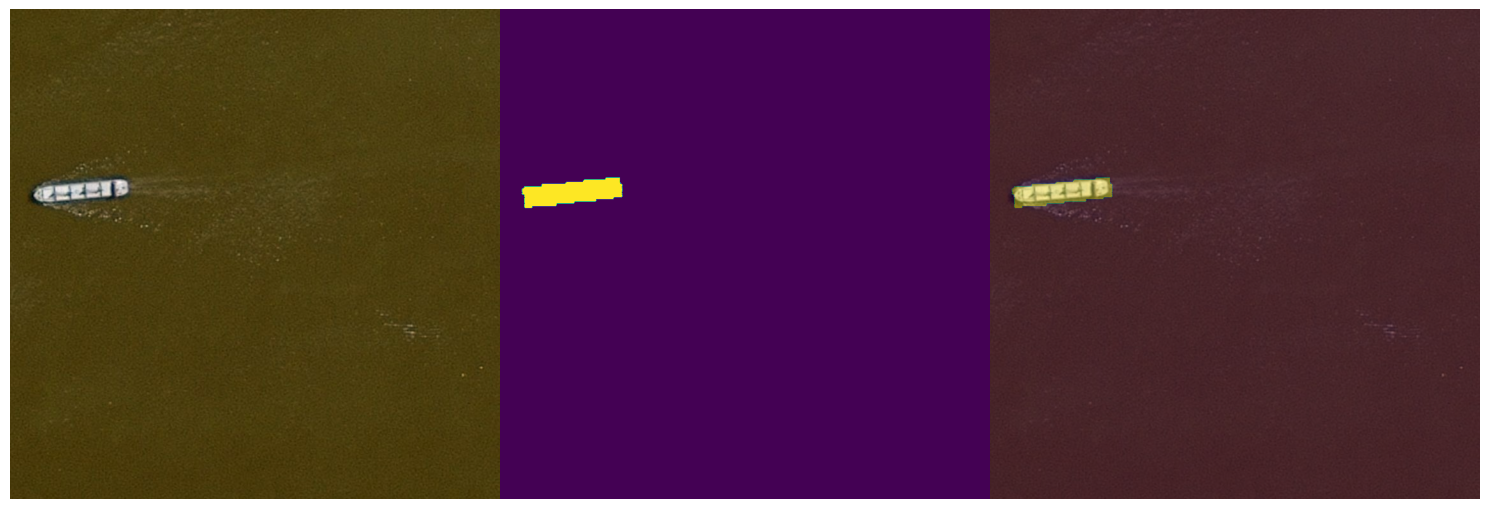

2it [00:01,  1.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


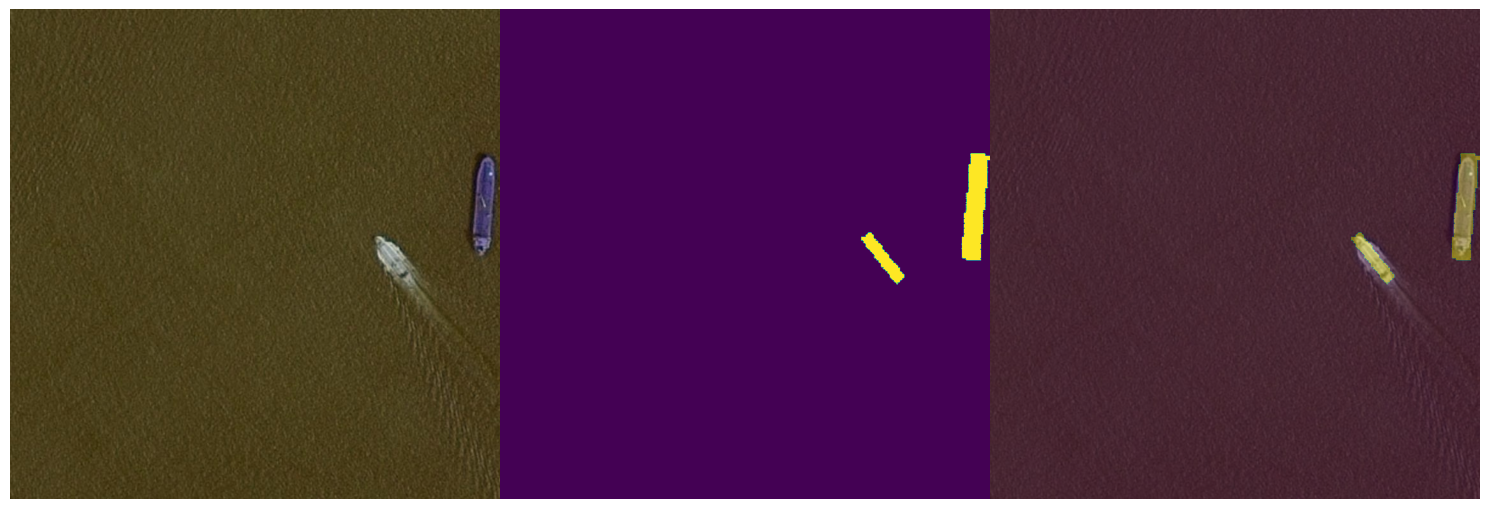

3it [00:02,  1.12it/s]

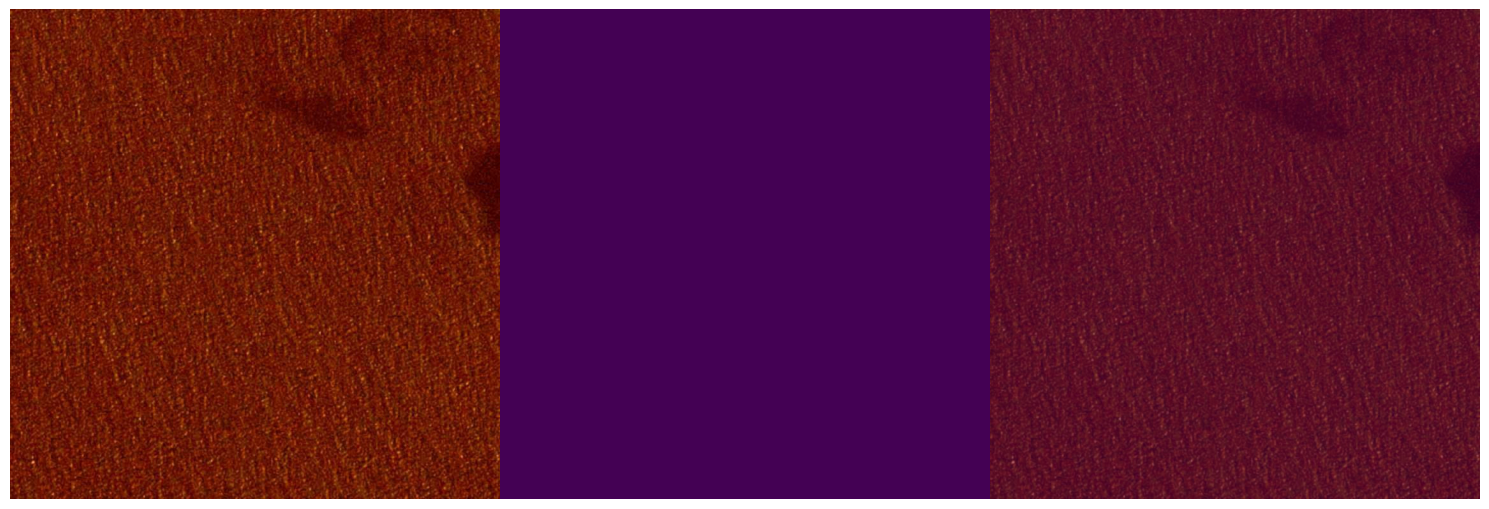

4it [00:03,  1.12it/s]

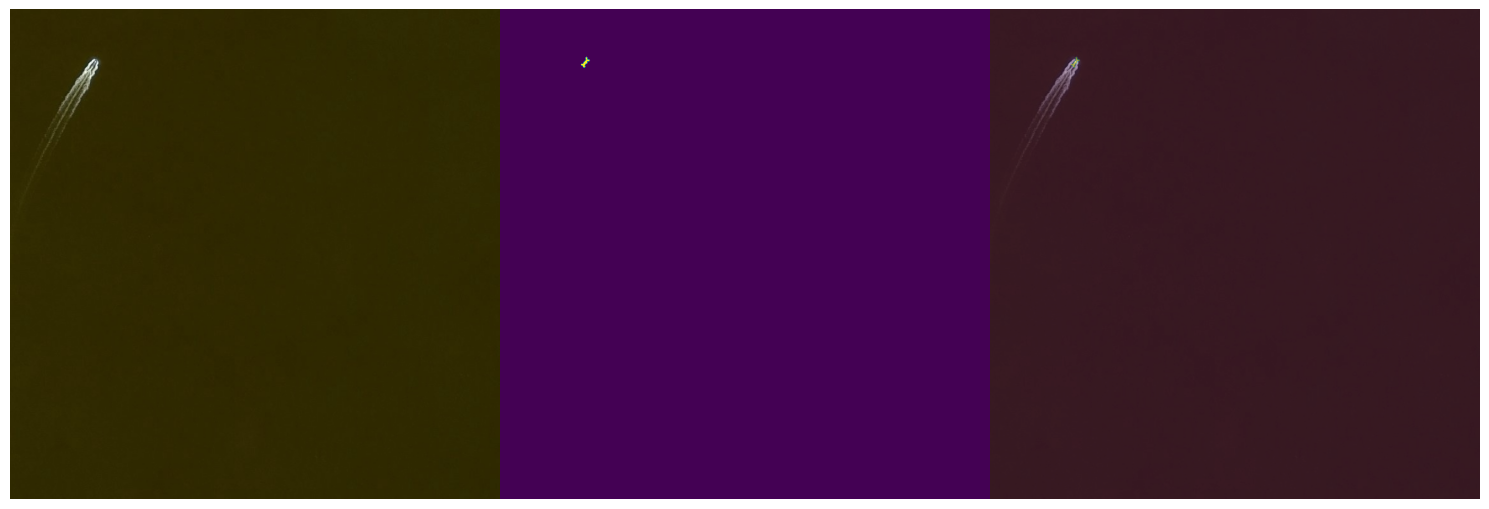

5it [00:04,  1.13it/s]


In [17]:
# Code for iterating a certain number of times a function and then saving images
for i, (image, masks) in tqdm(enumerate(train_loader)):
    masks = masks / 255
    if i < 5:
        show_image_with_mask(image, masks, 4, 4)
        plt.show()
    else:
        break

# At the end what i can say:
###
## We have a huge dataset that has some issues, but they will not affect the result, because they can be easily removed 
